In [385]:
import torch
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

In [399]:

class Vgg19(torch.nn.Module):
  def __init__(self):
        super(Vgg19, self).__init__()
        self.vgg19 = torchvision.models.vgg19(pretrained=True).eval()
        for param in self.vgg19.parameters():
          param.requires_grad = False
        self.style_layers,self.content_layers = [0,5,10,19,28],[25]

  def forward(self, x): 
      style_features = []
      content_features = []
      for idx,layer in enumerate(self.vgg19.features):
          x = layer(x)
          if idx in self.style_layers:
              style_features.append(x)
          if idx in self.content_layers:
              content_features.append(x)

      return style_features,content_features

to_input = torchvision.transforms.Compose([
  torchvision.transforms.Resize((224,224)),
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
  torchvision.transforms.Lambda(lambda x : x.unsqueeze(0))
])

to_output = torchvision.transforms.Compose([
  torchvision.transforms.Lambda(lambda x: x.squeeze(0)),
  torchvision.transforms.ToPILImage()
])

In [387]:
vgg = Vgg19()

In [388]:
content_image = to_input(Image.open("assets/cat.png"))
style_image = to_input(Image.open("assets/style.jpeg"))

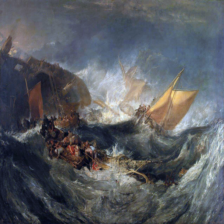

In [389]:
to_output(style_image)

In [408]:
def gram_matrix(input):
    b,c,h,w = input.shape
    F = input.view(b,c,h*w)
    G = torch.bmm(F,F.transpose(1,2))
    G.div_(h*w)
    return G
def gram_loss(input,target):
    return torch.nn.MSELoss()(gram_matrix(input),gram_matrix(target))

In [427]:
def fit(model, style_image, content_image,
              style_weight= 1e6, content_weight=1e3,
              style_layers= [0,1,2,3,4],content_layers=[0],
              style_weights= [0.2,0.2,0.2,0.2,0.2],
              epochs= 100, lr= 1e-1):

    _,target_content_features = model(content_image)
    target_style_features,_ = model(style_image)
    img= torch.randn_like(style_image).requires_grad_(True)
    opt= torch.optim.Adam([img],lr=lr)

    run=[0]
    while run[0] <= epochs:
        
        opt.zero_grad()

        style_features,content_features = model(img)

        content_loss = 0
        for idx,layer in enumerate(content_layers):
            content = content_features[layer]
            content_target = target_content_features[layer].detach()
            content_loss += torch.nn.MSELoss()(content,content_target)

        style_loss = 0
        for idx, layer in enumerate(style_layers):
            layer_style_loss = gram_loss(style_features[layer],target_style_features[layer].detach())
            style_loss += style_weights[idx] * layer_style_loss

        loss = content_weight * content_loss + style_weight * style_loss 
        loss.backward()

        if run[0] % 50 == 0:
            print(f"Epoch {run[0]} Loss = {loss.item():.3f}")
        run[0]+=1
            
        opt.step()

        
    with torch.no_grad():
        img.clamp_(0,1)
    return to_output(img)


In [430]:
new_img = fit(vgg,
    style_image,
    content_image,
    epochs= 4000,
    content_weight=1,
    style_weight=1e3,
    style_weights=[1e3/n**2 for n in [64,128,256,512,512]],
    lr=5)

Epoch 0 Loss = 7040.089
Epoch 50 Loss = 3.935
Epoch 100 Loss = 2.667
Epoch 150 Loss = 2.338
Epoch 200 Loss = 2.198
Epoch 250 Loss = 2.114


KeyboardInterrupt: 

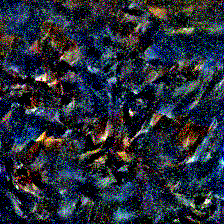

In [435]:
new_img